In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Version 1

Fixed hyperparameters

In [4]:
import pandas as pd
import numpy as np

# helper functions
def logit(p):
    return np.log(p) - np.log(1 - p)


def invlogit(theta):
    return 1 / (1 + np.exp(-theta))



d = 4


In [ ]:


def dirtymultilevel(
    n=np.repeat(100, d), phat=np.repeat(0.5, d), mu0=np.repeat(0, d), V0=None, return_ci=False
):
    if V0 is None:
        # note: V0 should generally be equal to the prior sigma-inverse
        V0 = np.diag(np.repeat(1, len(phat)))
    # phat += 1e-8
    thetahat = logit(phat)
    sample_I = np.diag(n * phat * (1 - phat))
    precision_posterior = V0 + sample_I
    Sigma_posterior = np.linalg.inv(precision_posterior)
    mu_posterior = Sigma_posterior @ (sample_I @ thetahat + V0 @ mu0)
    # mu_posterior = np.linalg.solve(precision_posterior, sample_I @ thetahat + V0 @ mu0)
    ci_dict = {}
    if return_ci:
        # implement 95% CI on each arm
        CI_upper_logit = mu_posterior + 1.96 * np.sqrt(np.diag(Sigma_posterior))
        median_logit = mu_posterior
        CI_lower_logit = mu_posterior - 1.96 * np.sqrt(np.diag(Sigma_posterior))
        conf_logit = pd.DataFrame(
            np.column_stack([CI_lower_logit, median_logit, CI_upper_logit]),
            columns=("lower", "median", "upper"),
        )
        conf_prob = conf_logit.apply(invlogit, axis=1)
        ci_dict['conf_logit']=conf_logit
        ci_dict['conf_prob']=conf_prob
    return dict(
        mu_posterior=mu_posterior,
        Sigma_posterior=Sigma_posterior,
        **ci_dict,
    )

# dirtymultilevel()

# Version 2

First attempt at integrating the hyperparameters.

In [4]:
import quadpy

d = 4
p_threshold = np.repeat(0.4, d)


def fast_invert(S, d):
    for k in range(len(d)):
        offset = (d[k] / (1 + d[k] * S[k, k])) * np.outer(
            S[k],
            S[..., k],
        )  # I wonder how to cheaply represent this outer? but in C++ it should be just a trivial for-loop anyway
        S = S - offset
    return S


# TODO: vectorize this in terms of sigma_sq
def conditional_exceed_prob_given_sigma(
    sigma_sq: float,
    mu_sig_sq: float,
    thresh=logit(p_threshold),
    n=np.repeat(100, d),
    phat=np.repeat(0.5, d),
    mu_0=np.repeat(0, d),
):
    assert len(sigma_sq) == 1, sigma_sq
    S_0 = np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq
    # V_0 = solve(S_0) #but because this is a known case of the form aI + bJ, we can use the explicit
    # inverse formula, given by: 1/a I - J*(b/(a(a+db)))
    V_0 = np.diag(np.repeat(1 / sigma_sq, d)) - (mu_sig_sq / sigma_sq) / (
        sigma_sq + d * mu_sig_sq
    )  # Note, by the way, that it's probably possible to use significant precomputation here
    thetahat = logit(phat)
    sample_I = n * phat * (1 - phat)  # diag(n*phat*(1-phat))
    Sigma_posterior = fast_invert(S_0, sample_I)
    # precision_posterior = V_0 + np.diag(sample_I)
    # Sigma_posterior = np.linalg.inv(precision_posterior)
    mu_posterior = Sigma_posterior @ (sample_I * thetahat + V_0 @ mu_0)

    # What we now must return instead, is posterior threshold exceedance probabilities for each arm.
    z_scores = (mu_posterior - thresh) / np.sqrt(np.diag(Sigma_posterior))
    # return(list( thresh_exceed = thresh_exceed, mu_posterior = mu_posterior, Sigma_posterior = Sigma_posterior ))
    return z_scores


n = 50
# let's evaluate the endpoints of the prior in logspace-sigma:
# determine endpoints:
def get_false_rejections():
    a = np.log(1e-8)
    b = np.log(1e3)

    gleg = quadpy.c1.gauss_legendre(n)
    pts = (gleg.points + 1) * (b - a) / 2 + a
    wts = gleg.weights * (b - a) / 2  # sum(wts) = b-a so it averages to 1 over space
    density_logspace = scipy.stats.invgamma.pdf(
        np.exp(pts), a=0.0005, scale=0.000005
    ) * np.exp(pts)
    exceed_probs = np.apply_along_axis(
        conditional_exceed_prob_given_sigma,
        0,
        np.exp(pts)[np.newaxis],
        mu_sig_sq=0.1,
        n=np.repeat(50, d),
        phat=np.array([28, 14, 33, 36]) / 50,
        mu_0=np.repeat(0, d),
    )

    contributions = (
        exceed_probs.T
        * density_logspace[:, np.newaxis]
        * wts[:, np.newaxis]
        / np.sum(density_logspace * wts)
    )  # this automatically fills in density_logspace by column
    # Now, the final step is to sum
    posterior_exceedance_prob = np.sum(contributions, 0)
    return posterior_exceedance_prob


expected = [3.18017917, 1.04572162, 3.88130924, 4.2472914]
# %timeit -r 15 got = get_false_rejections()
got = get_false_rejections()
assert np.allclose(expected, got), got


ModuleNotFoundError: No module named 'quadpy'

# Version 3

Note this version does not properly integrate the hyperparameters.

In [ ]:
d = 4
p_threshold = np.repeat(0.4, d)


def fast_invert(S, d):
    for k in range(len(d)):
        offset = (d[k] / (1 + d[k] * S[k, k])) * np.outer(
            S[k],
            S[..., k],
        )  # I wonder how to cheaply represent this outer? but in C++ it should be just a trivial for-loop anyway
        S = S - offset
    return S


# TODO: vectorize this in terms of sigma_sq
# P(X | Y, theta)
def conditional_exceed_prob_given_sigma(
    sigma_sq: float,
    mu_sig_sq: float,
    sample_I,
    thetahat,
    thresh=logit(p_threshold),
    mu_0=np.repeat(0, d),
):
    assert len(sigma_sq) == 1, sigma_sq
    S_0 = np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq
    # V_0 = solve(S_0) #but because this is a known case of the form aI + bJ, we can use the explicit
    # inverse formula, given by: 1/a I - J*(b/(a(a+db)))
    V_0 = np.diag(np.repeat(1 / sigma_sq, d)) - (mu_sig_sq / sigma_sq) / (
        sigma_sq + d * mu_sig_sq
    )  # Note, by the way, that it's probably possible to use significant precomputation here
    Sigma_posterior = fast_invert(S_0, sample_I)
    # precision_posterior = V_0 + np.diag(sample_I)
    # Sigma_posterior = np.linalg.inv(precision_posterior)
    mu_posterior = Sigma_posterior @ (sample_I * thetahat + V_0 @ mu_0)

    # What we now must return instead, is posterior threshold exceedance probabilities for each arm.
    z_scores = (mu_posterior - thresh) / np.sqrt(np.diag(Sigma_posterior))
    # return(list( thresh_exceed = thresh_exceed, mu_posterior = mu_posterior, Sigma_posterior = Sigma_posterior ))
    return z_scores


# let's evaluate the endpoints of the prior in logspace-sigma:
# determine endpoints:
def get_false_rejections():

    # Shared for a given prior
    a = np.log(1e-8)
    b = np.log(1e3)
    n = 50
    pts, weights = np.polynomial.legendre.leggauss(n)
    pts = (pts + 1) * (b - a) / 2 + a
    wts = weights * (b - a) / 2  # sum(wts) = b-a so it averages to 1 over space
    density_logspace = scipy.stats.invgamma.pdf(
        np.exp(pts), a=0.0005, scale=0.000005
    ) * np.exp(pts)

    # Shared for a given phat
    phat = np.array([28, 14, 33, 36]) / 50
    thetahat = logit(phat)
    sample_I = n * phat * (1 - phat)  # diag(n*phat*(1-phat))

    exceed_probs = np.apply_along_axis(
        conditional_exceed_prob_given_sigma,
        0,
        np.exp(pts)[np.newaxis],
        mu_sig_sq=0.1,  # TODO: integrate over this too
        sample_I=sample_I,
        thetahat=thetahat,
        mu_0=np.repeat(0, d),
    )

    contributions = (
        exceed_probs.T
        * density_logspace[:, np.newaxis]
        * wts[:, np.newaxis]
        / np.sum(density_logspace * wts)
    )  # this automatically fills in density_logspace by column
    # Now, the final step is to sum
    posterior_exceedance_prob = np.sum(contributions, 0)
    return posterior_exceedance_prob


expected = [3.18017917, 1.04572162, 3.88130924, 4.2472914]
# %timeit -r 15 got = get_false_rejections()
got = get_false_rejections()
assert np.allclose(expected, got), got


# Version 4

With proper hyperparameter integration.

In [5]:
import numpy as np
import scipy.stats

def log_args(f):
    def wrapper(*args, **kwargs):
        print(f)
        for arg in args:
            print(arg)
        for k,v in kwargs.items():
            print(k, v)
        return f(*args, **kwargs)
    return wrapper

def fast_invert(S, d):
    for k in range(len(d)):
        offset = (d[k] / (1 + d[k] * S[k, k])) * np.outer(
            S[k],
            S[..., k],
        )  # I wonder how to cheaply represent this outer? but in C++ it should be just a trivial for-loop anyway
        S = S - offset
    return S


# TODO: vectorize this in terms of sigma_sq
# P(X | Y, theta)
def conditional_exceed_prob_given_sigma(
    sigma_sq: float,
    mu_sig_sq: float,
    sample_I,
    thetahat,
    thresh,
    mu_0,
):
    assert len(sigma_sq) == 1, sigma_sq
    S_0 = np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq
    # V_0 = solve(S_0) #but because this is a known case of the form aI + bJ, we can use the explicit
    # inverse formula, given by: 1/a I - J*(b/(a(a+db)))
    V_0 = np.diag(np.repeat(1 / sigma_sq, d)) - (mu_sig_sq / sigma_sq) / (
        sigma_sq + d * mu_sig_sq
    )  # Note, by the way, that it's probably possible to use significant precomputation here
    Sigma_posterior = fast_invert(S_0, sample_I)
    # precision_posterior = V_0 + np.diag(sample_I)
    # Sigma_posterior = np.linalg.inv(precision_posterior)
    mu_posterior = Sigma_posterior @ (sample_I * thetahat + V_0 @ mu_0)

    # What we now must return instead, is posterior threshold exceedance probabilities for each arm.
    z_scores = (mu_posterior - thresh) / np.sqrt(np.diag(Sigma_posterior))
    quantiles = scipy.stats.norm.cdf(z_scores)
    # return(list( thresh_exceed = thresh_exceed, mu_posterior = mu_posterior, Sigma_posterior = Sigma_posterior ))
    return quantiles


# let's evaluate the endpoints of the prior in logspace-sigma:
# determine endpoints:
def get_false_rejections():

    # Shared for a given prior
    a = np.log(1e-8)
    b = np.log(1e3)
    n_points = 50
    mu_sig_sq = 100
    mu_0 = -1.34
    phat = np.array([3, 8, 5, 4]) / 15
    d = 4
    n = np.repeat(15, d)
    p_threshold = np.repeat(0.3, d)
    thetahat = logit(phat)
    sample_I = n * phat * (1 - phat)  # diag(n*phat*(1-phat))
    pts, weights = np.polynomial.legendre.leggauss(n_points)
    pts = (pts + 1) * (b - a) / 2 + a
    wts = weights * (b - a) / 2  # sum(wts) = b-a so it averages to 1 over space
    density_logspace = scipy.stats.invgamma.pdf(
        np.exp(pts), a=0.0005, scale=0.000005
    ) * np.exp(pts)

    density_sigma_given_y = [scipy.stats.multivariate_normal.pdf(
        thetahat, np.repeat(mu_0, d), np.diag(sample_I**-1) + np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq
    ) for sigma_sq in np.exp(pts)]
    # for pt in np.exp(pts):
        # print(np.diag(sample_I**-1) + np.diag(np.repeat(pt, d)) + mu_sig_sq)
    density_sigma_given_y = np.array(density_sigma_given_y)
    print(density_sigma_given_y / density_sigma_given_y.sum())
    final_weights = wts * density_logspace * density_sigma_given_y
    final_weights /= np.sum(final_weights)

    # Shared for a given phat

    exceed_probs = np.apply_along_axis(
        conditional_exceed_prob_given_sigma,
        0,
        np.exp(pts)[np.newaxis],
        mu_sig_sq=mu_sig_sq,  # TODO: integrate over this too
        sample_I=sample_I,
        thetahat=thetahat,
        mu_0=np.repeat(mu_0, d),
        thresh=logit(p_threshold)
    )
    # print(exceed_probs.T)

    contributions = (
        exceed_probs.T * final_weights[:,np.newaxis]
    )  # this automatically fills in density_logspace by column
    # Now, the final step is to sum
    posterior_exceedance_prob = np.sum(contributions, 0)
    return posterior_exceedance_prob


expected = [0.64462095, 0.80224266, 0.71778699, 0.67847136]
# %timeit -r 15 got = get_false_rejections()
got = get_false_rejections()
assert np.allclose(expected, got), got

[3.00299244e-02 3.00299244e-02 3.00299245e-02 3.00299246e-02
 3.00299248e-02 3.00299251e-02 3.00299255e-02 3.00299262e-02
 3.00299273e-02 3.00299291e-02 3.00299322e-02 3.00299377e-02
 3.00299477e-02 3.00299664e-02 3.00300022e-02 3.00300724e-02
 3.00302134e-02 3.00305023e-02 3.00311052e-02 3.00323834e-02
 3.00351282e-02 3.00410820e-02 3.00540804e-02 3.00825171e-02
 3.01444616e-02 3.02773919e-02 3.05527505e-02 3.10798165e-02
 3.19159606e-02 3.26454514e-02 3.15634637e-02 2.62728809e-02
 1.75107313e-02 9.43518655e-03 4.40301485e-03 1.91396141e-03
 8.15889051e-04 3.51589355e-04 1.55709005e-04 7.14938121e-05
 3.42088566e-05 1.71310578e-05 9.02379915e-06 5.03134922e-06
 2.99065068e-06 1.90866517e-06 1.31626919e-06 9.85967983e-07
 8.05308685e-07 7.19033265e-07]


-6.586251363200169
[      -inf 1.21570522 3.02220896 3.44987362 3.57871396 3.60545859
 3.58971237 3.55453212 3.51021958 3.46182203]


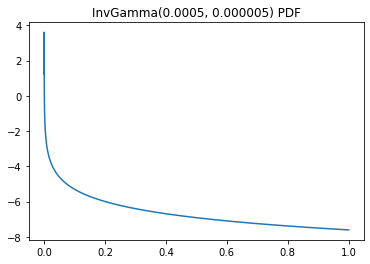

In [7]:
import scipy.stats
import matplotlib.pyplot as plt
n = 1000000
x = np.linspace(0, 1, 1000000)
y = scipy.stats.invgamma.logpdf(x, a=0.0005, scale=0.000005)
plt.plot(x, y)
# plt.xlim(0, .01)
plt.title("InvGamma(0.0005, 0.000005) PDF")
print(np.sum(y[int(n*.01):]) /n )
print(y[:10])

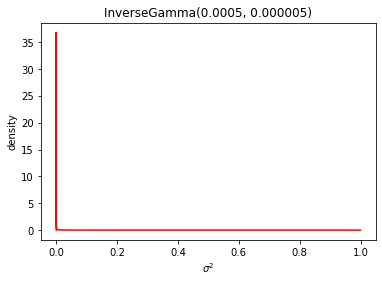

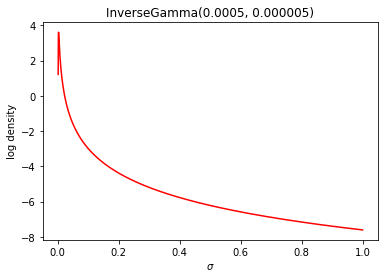

In [8]:
alpha = 0.0005
beta = 0.000005
invgamma = scipy.stats.invgamma
# x = np.linspace(invgamma.ppf(0.001, alpha, scale=beta), invgamma.ppf(0.999, alpha, scale=beta), 100)
# x = np.linspace(0, 1.0, 1000000)
plt.plot(x, invgamma.pdf(x, alpha, scale=beta), "r-", label="invgamma pdf")
plt.ylabel('density')
plt.xlabel('$\sigma^2$')
plt.title('InverseGamma(0.0005, 0.000005)')
plt.show()

plt.plot(np.sqrt(x), invgamma.logpdf(x, alpha, scale=beta), "r-", label="invgamma pdf")
plt.ylabel('log density')
plt.xlabel('$\sigma$')
plt.title('InverseGamma(0.0005, 0.000005)')
plt.show()


In [9]:
import scipy.stats
import matplotlib.pyplot as plt


def logit_normal_pdf(x, loc, scale):
    return (
        np.sqrt(scale * 2 * np.pi) ** -1
        * (x * (1 - x)) ** -1
        * np.exp(-((logit(x) - loc) ** 2) / (2 * scale))
    )


n = 50
a = 3
b = 3
aobserved = 1

def compare_dirty(n, a, b, p):
    aobserved = n*p
    approximation = dirtymultilevel(
        n=np.repeat(n, d),
        phat=np.array([aobserved]) / n,
        mu0=np.repeat(0, d),
        V0=np.diag(np.repeat(1, d)),
    )
    mu = approximation["mu_posterior"][0]
    sigma = approximation["Sigma_posterior"][0][0]
    x = np.arange(0, 1, 0.005)
    y = scipy.stats.beta(a=a + aobserved, b=b + n - aobserved).pdf(x)
    y2 = logit_normal_pdf(x, mu, sigma)
    plt.figure(figsize=(9, 6))
    plt.plot(x, y, label=f"binomial({a+aobserved},{b+n-aobserved})")
    plt.plot(x, y2, label=f"logit-normal({mu:.2f},{sigma:.2f})")
    plt.title("PDFs")
    plt.xlim(0, 0.5)
    plt.legend()


import ipywidgets as widgets
w = widgets.interactive(compare_dirty, n=(5,100), a=(0,3), b=(0,3), p=(0,1, 0.1))
# from IPython.display import display
# display(w)
output = w.children[-1]
output.layout.height = '550px'
w

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
import unittest


class TestDirtyMultiLevel(unittest.TestCase):
    def test(self):
        want = dict(
            mu_posterior=np.array([0.2230568, -0.85922139, 0.60901482, 0.85922139]),
            Sigma_posterior=np.array(
                [
                    [0.07507508, 0.0, 0.0, 0.0],
                    [0.0, 0.09025271, 0.0, 0.0],
                    [0.0, 0.0, 0.08183306, 0.0],
                    [0.0, 0.0, 0.0, 0.09025271],
                ]
            ),
            conf_logit=np.array(
                [
                    [-0.31397989, 0.2230568, 0.76009349],
                    [-1.44804632, -0.85922139, -0.27039646],
                    [0.04832785, 0.60901482, 1.1697018],
                    [0.27039646, 0.85922139, 1.44804632],
                ]
            ),
            conf_prob=np.array(
                [
                    [0.42214359, 0.55553413, 0.68137403],
                    [0.19030242, 0.29750204, 0.43280977],
                    [0.51207961, 0.64771604, 0.76309111],
                    [0.56719023, 0.70249796, 0.80969758],
                ]
            ),
        )

        # This one is intended to match Ben's example!
        got = dirtymultilevel(
            n=np.repeat(50, d),
            phat=np.array([28, 14, 33, 36]) / 50,
            mu0=np.repeat(0, d),
            V0=np.diag(np.repeat(1, d)),
            return_ci=True,
        )

        for key in want:
            self.assertTrue(
                np.allclose(want[key], got[key]),
                "dictionary values should be almost equal",
            )


unittest.main(argv=["first-arg-is-ignored"], exit=False)


E
ERROR: test (__main__.TestDirtyMultiLevel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_11462/3755438007.py", line 36, in test
    n=np.repeat(50, d),
  File "<__array_function__ internals>", line 180, in repeat
  File "/home/const/.local/share/virtualenvs/inla_explore-cHlb9J0F/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 479, in repeat
    return _wrapfunc(a, 'repeat', repeats, axis=axis)
  File "/home/const/.local/share/virtualenvs/inla_explore-cHlb9J0F/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 54, in _wrapfunc
    return _wrapit(obj, method, *args, **kwds)
  File "/home/const/.local/share/virtualenvs/inla_explore-cHlb9J0F/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 43, in _wrapit
    result = getattr(asarray(obj), method)(*args, **kwds)
TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

--------